- Valider le sujet à prédire (prédire treatment) => OK
- S'accorder sur l'hypothese : étude sur les USA ? ou tous les pays ? => le monde

- Sous Tableau, explorer les données et créer des graphes pour essayer de déterminer des liens entre la variable dépendante (treatment)
    et les variables indépendantes

- S'accorder sur le préprocessing des données
    - Supprimer Comment, Timestamp et State (si étude sur tous les pays)
    - Quid des genres ? (regrouper en 3 ? Male, Female, Other ?)
    - Quid des NA ? (voir la proportion que cela représente sur une colonne et sur l'échantillon, peut être remplacer par une valeur définie)
    - Quel encodage par colonne ? (il y a de l'ordinale, du scaler, du onehot, labelEncoder pour y)

- Développement
    - Preprocessing
    - Régression logistique + matrice de confusion (accuracy score)
    - Random Forest  + matrice de confusion (accuracy score)
    - Comparaison des deux (de leur efficacité)
    - Études avec Recall, F1, etc.
    
- Préparer les slides
    - la problématique
    - la question à répondre
    - nos explorations et premières "analyses"
    - le(s) modèle(s) utilisés
    - les résultats
    - ouverture sur ce que l'on aura pu faire de plus 
    - ouverture sur une autre question que l'on aurait pu répondre 

In [141]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

import time

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [142]:
df = pd.read_csv("/Users/qxzjy/vscworkspace/dse-ft-100/final_project/data/survey.csv")
display(df.head())

display(df.isnull().any())

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


Timestamp                    False
Age                          False
Gender                       False
Country                      False
state                         True
self_employed                 True
family_history               False
treatment                    False
work_interfere                True
no_employees                 False
remote_work                  False
tech_company                 False
benefits                     False
care_options                 False
wellness_program             False
seek_help                    False
anonymity                    False
leave                        False
mental_health_consequence    False
phys_health_consequence      False
coworkers                    False
supervisor                   False
mental_health_interview      False
phys_health_interview        False
mental_vs_physical           False
obs_consequence              False
comments                      True
dtype: bool

In [143]:
print("Aggregation des valeurs difficilement exploitables...")

africa = [
    'Nigeria', 'South Africa', 'Zimbabwe'
]
australia = [
    'Australia', 'New Zealand'
]
asia = [
    'China', 'India', 'Israel', 'Japan', 'Philippines', 'Russia', 'Singapore', 'Thailand'
]
europe = [
    'Austria', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Czech Republic',
    'Denmark', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy',
    'Latvia', 'Moldova', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Spain', 'Sweden',
    'United Kingdom', 'Slovenia', 'Switzerland'
]
north_america = [
    'Bahamas, The', 'Canada', 'Costa Rica', 'Mexico', 'United States'
]
south_america = [
    'Brazil', 'Colombia', 'Uruguay'
]

def continent_by_country(country):
    country_str = str(country).strip()
    if country_str in africa:
        return 'Africa'
    elif country_str in australia:
        return 'Australia'
    elif country_str in asia:
        return 'Asia'
    elif country_str in europe:
        return 'Europe'
    elif country_str in north_america:
        return 'North America'
    elif country_str in south_america:
        return 'South America'
    else:
        return 'Undefined'

df['Continent'] = df['Country'].apply(continent_by_country)

male_values = [
    'Male', 'male', 'make','Make' 'M', 'm','Man', 'msle', 'Mail', 'Malr', 'Cis male',
    'Cis man','Cis Man','cis male', "Guy (-ish) ^_^", 'Male (CIS)', 'Male-ish', 'maile', 'Maile',
    'something kinda male?', 'Mal', 'ostensibly male, unsure what that really means', 'cis Male', 'Make' 
]
male_values = [x.lower() for x in male_values]

female_values = [
    'Female', 'F','f', 'woman', 'Female (trans)', 'Trans woman', 'Female (cis)',
    'cis-female/femme', 'femail', 'Trans-female', 'Cis Female', 'Femake'
]
female_values = [x.lower() for x in female_values]

queer_non_binary_values = [
    'Neuter', 'Agender', 'Androgyne', 'non-binary', 'All', 'fluid', 'Enby', 'queer',
    'Genderqueer', 'queer/she/they', 'male leaning androgynous'
]
queer_non_binary_values = [x.lower() for x in queer_non_binary_values]

df['Gender'] = [x.lower() for x in df['Gender']]

def normalize_gender(gender):
    gender_str = str(gender).strip()
    if gender_str in male_values:
        return 'Male'
    elif gender_str in female_values:
        return 'Female'
    elif gender_str in queer_non_binary_values:
        return 'Queer/Non-binary'
    else:
        return 'Other'
df['Gender2'] = df['Gender'].apply(normalize_gender)

print("...Fait")


Aggregation des valeurs difficilement exploitables...
...Fait


In [144]:

print("Suppression des variables indépendantes non-pertinentes...")

df = df.drop('Timestamp', axis=1)

df = df.drop('comments', axis=1)

df = df.drop('state', axis=1)

df = df.drop('Gender', axis=1)

df = df.drop('Country', axis=1)

print("...Fait")

Suppression des variables indépendantes non-pertinentes...
...Fait


In [145]:
print("Suppression des lignes non-pertinentes...")

df = df.drop(df[df.Gender2 == "Other"].index)
df = df.drop(df[df.tech_company == "No"].index)
df = df.drop('tech_company', axis=1)
print("...Fait")


Suppression des lignes non-pertinentes...
...Fait


In [146]:

print("Attribution de valeurs pour les champs manquants ou incohérents...")

df.loc[(df['self_employed'].isnull()) & (df['no_employees'] == "1-5"), 'self_employed'] = "Yes"
df.loc[(df['self_employed'].isnull()) & (df['no_employees'] != "1-5"), 'self_employed'] = "No"

df.loc[df['work_interfere'].isnull(), 'work_interfere'] = "Not answered"

df.loc[(df['Age'] == -1), 'Age'] = df["Age"].median()
df.loc[(df['Age'] == -29), 'Age'] = df["Age"].median()
df.loc[(df['Age'] == -1726), 'Age'] = df["Age"].median()
df.loc[(df['Age'] == 99999999999), 'Age'] = df["Age"].median()
df.loc[(df['Age'] == 329), 'Age'] = df["Age"].median()

print("...Fait")

Attribution de valeurs pour les champs manquants ou incohérents...
...Fait


In [147]:
print("Génération d'un nouveau fichier pour l'EDA dans Tableau...")

# df.to_csv("/Users/qxzjy/vscworkspace/dse-ft-100/final_project/data/survey_cleaned.csv", index=False)

print("...Fait")

Génération d'un nouveau fichier pour l'EDA dans Tableau...
...Fait


In [148]:
print("Séparation des variables indépendantes et dépendantes...")

features_list = [column_name for index, column_name in enumerate(df.columns) if column_name not in ["treatment"]]
X = df.loc[:, features_list]
y = df.loc[:,"treatment"]

print("...Fait")

Séparation des variables indépendantes et dépendantes...
...Fait


In [149]:
print("Séparation du jeu de données en un jeu de données d'entrainement et de test...")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

print("...Fait")

Séparation du jeu de données en un jeu de données d'entrainement et de test...
...Fait


In [150]:
print("----- Entrainement -----")

----- Entrainement -----


In [151]:
print("Encodage des variables indépendantes catégorielles et standardisation des numériques...")

numeric_features = [i for i, item in enumerate(X_train.columns) if X_train[item].dtype in ["int64", "float64"]]
numeric_transformer = StandardScaler()

categorical_features = [i for i, item in enumerate(X_train.columns) if X_train[item].dtype in ["object", "str", "category"]]
categorical_features_names = [item for i, item in enumerate(X_train.columns) if (X_train[item].dtype in ["object", "str", "category"])]
categorical_transformer = OneHotEncoder(drop='first')

nb_elements_after_drop=[]

for i in range(1, len(X_train.columns)) :
    nb_elements_after_drop.append(len(X_train.iloc[:,i].unique())-1)

feature_encoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),    
        ('num', numeric_transformer, numeric_features)
    ]
)

X_train_transformed = feature_encoder.fit_transform(X_train)

labelencoder = LabelEncoder()
y_train_transformed = labelencoder.fit_transform(y_train)

print("...Fait")

Encodage des variables indépendantes catégorielles et standardisation des numériques...
...Fait


In [152]:
print("Entrainement du modele...")
start_time = time.perf_counter()

classifier = LogisticRegression()
classifier.fit(X_train_transformed, y_train_transformed)

end_time = time.perf_counter()
total_time = (end_time - start_time)*1000

print(f"Temps d'execution : {total_time:.3f}")
print("...Fait")

Entrainement du modele...
Temps d'execution : 4.292
...Fait


In [153]:
print("Prédiction sur le jeu de données d'entrainement...")

y_train_pred = classifier.predict(X_train_transformed)

print("...Fait")

Prédiction sur le jeu de données d'entrainement...
...Fait


In [154]:
print("----- Test -----")

----- Test -----


In [155]:
print("Encodage des variables indépendantes catégorielles et standardisation des numériques...")

X_test_transformed = feature_encoder.transform(X_test)

y_test_transformed = labelencoder.transform(y_test)

print("...Fait")

Encodage des variables indépendantes catégorielles et standardisation des numériques...
...Fait


In [156]:
print("Prédiction sur le jeu de données de test...")

y_test_pred = classifier.predict(X_test_transformed)

print("...Fait")

Prédiction sur le jeu de données de test...
...Fait


--- Evaluation des performances du modele ---


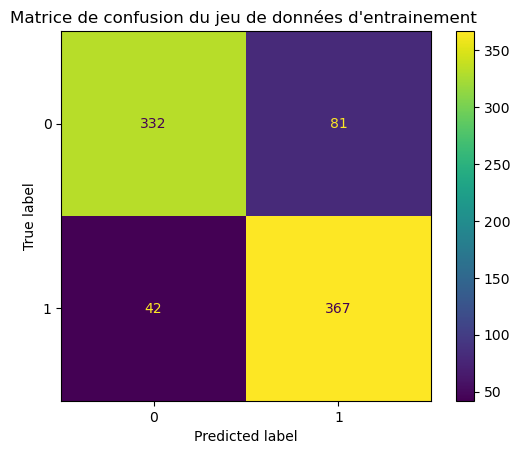

Score de précision du jeu de données d'entrainement' :  0.8503649635036497


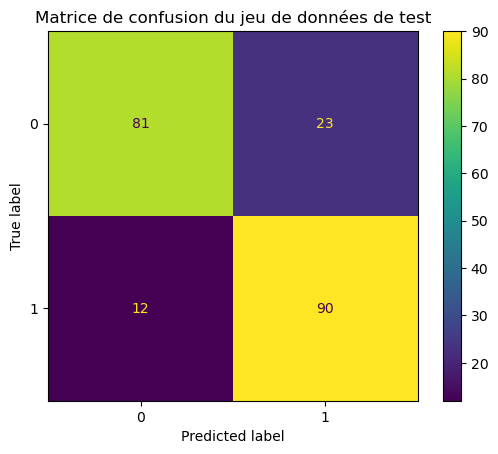

Score de précision du jeu de données de test :  0.8300970873786407


In [157]:
print("--- Evaluation des performances du modele ---")

cm_display = ConfusionMatrixDisplay.from_predictions(y_train_transformed, y_train_pred)
cm_display.ax_.set_title("Matrice de confusion du jeu de données d'entrainement ") # Simply to set a title
plt.show()
print("Score de précision du jeu de données d'entrainement' : ", classifier.score(X_train_transformed, y_train_transformed))

cm_display = ConfusionMatrixDisplay.from_predictions(y_test_transformed, y_test_pred)
cm_display.ax_.set_title("Matrice de confusion du jeu de données de test") # Simply to set a title
plt.show()
print("Score de précision du jeu de données de test : ", classifier.score(X_test_transformed, y_test_transformed))

In [158]:
print("Les coefficients sont : ", classifier.coef_) 
print("La constante est : ", classifier.intercept_)

Les coefficients sont :  [[-1.96081339e-01  1.10302176e+00 -1.76747964e+00  2.83313113e+00
   2.09361090e+00  2.54400530e+00  2.09861986e-01  4.09735750e-01
  -1.58704973e-01  1.97702478e-01  5.46328588e-02 -2.64891588e-02
   3.78789199e-01  6.42830033e-01  1.55570093e-02  7.30524268e-01
   6.79725430e-04 -6.23153114e-01 -3.45189144e-01 -1.60947792e-02
  -6.45319063e-01  3.70772863e-01  2.55002316e-01 -3.47854939e-01
   4.17774363e-02  1.90448629e-01 -4.71410280e-01 -4.42543756e-02
   2.37278939e-01 -1.29075236e-01  4.90330939e-01  8.65100793e-01
  -1.50579284e-01 -7.54711987e-02  2.95687264e-01  4.72440881e-01
   9.12989282e-02  2.81881988e-01 -6.04937013e-02 -2.73029935e-02
  -5.34078008e-02 -5.97721018e-01 -1.83100474e-01  2.81594134e-01
   8.67870193e-02 -1.02984923e-01 -9.40016182e-01  1.68294340e-01
   2.74303874e-01]]
La constante est :  [-2.41247858]


In [159]:
numerical_column_names = X.iloc[:, numeric_features].columns

all_column_names = np.append(categorical_features_names, numerical_column_names)
print(" Toutes les colonnes : ", all_column_names)


def getCoefAggregateByColumns(coef_features):
    coef_aggregate = []

    coefs = coef_features.tolist()

    for i in range (0, len(nb_elements_after_drop)) :
        coef_aggregate.append(np.mean(coefs[:nb_elements_after_drop[i]]))

        for y in range (nb_elements_after_drop[i]) :
            coefs.pop(0)

    coef_aggregate.append(coefs[0])

    return coef_aggregate


coef_aggregate_by_columns = getCoefAggregateByColumns(classifier.coef_.squeeze())

 Toutes les colonnes :  ['self_employed' 'family_history' 'work_interfere' 'no_employees'
 'remote_work' 'benefits' 'care_options' 'wellness_program' 'seek_help'
 'anonymity' 'leave' 'mental_health_consequence' 'phys_health_consequence'
 'coworkers' 'supervisor' 'mental_health_interview'
 'phys_health_interview' 'mental_vs_physical' 'obs_consequence'
 'Continent' 'Gender2' 'Age']


In [160]:

feature_importance = pd.DataFrame({
    "feature_names": all_column_names,
    "coefficients":coef_aggregate_by_columns
})

feature_importance.coefficients.sort_values()

20   -0.385861
7    -0.311237
11   -0.257832
0    -0.196081
8    -0.180642
9    -0.137273
14   -0.113025
19   -0.103085
18   -0.053408
17   -0.043898
4    -0.026489
10    0.034843
12    0.054102
3     0.142646
16    0.186590
21    0.274304
6     0.373041
15    0.384064
5     0.510810
13    0.677716
1     1.103022
2     1.425817
Name: coefficients, dtype: float64

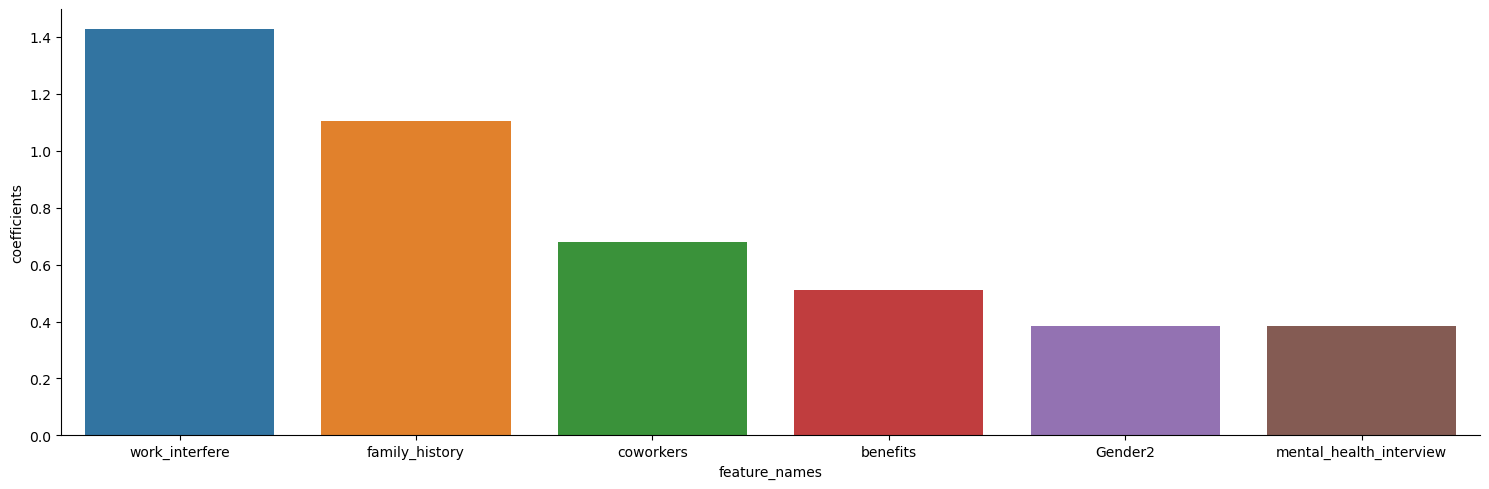

In [161]:
feature_importance["coefficients"] = feature_importance["coefficients"].abs()

sns.catplot(x="feature_names", 
            y="coefficients", 
            data=feature_importance.sort_values(by="coefficients", ascending=False).head(6), 
            kind="bar",
            aspect=30/10,
            hue='feature_names')

In [162]:
print("Entrainement du modele...")
start_time_rf = time.perf_counter()

classifier_rf = RandomForestClassifier(min_samples_split=100, class_weight='balanced', n_estimators=1000)
classifier_rf.fit(X_train_transformed, y_train_transformed)

end_time_rf = time.perf_counter()
total_time_rf = (end_time_rf - start_time_rf)*1000

print(f"Temps d'execution : {total_time_rf:.3f}")
print("...Fait")

Entrainement du modele...
Temps d'execution : 417.916
...Fait


Prédiction sur le jeu de données d'entrainement'...
...Fait
Prédiction sur le jeu de données de test...
...Fait
--- Evaluation des performances du modele ---


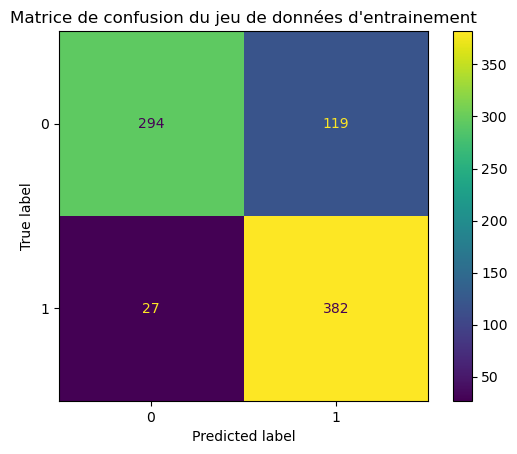

Score de précision du jeu de données d'entrainement 0.8223844282238443


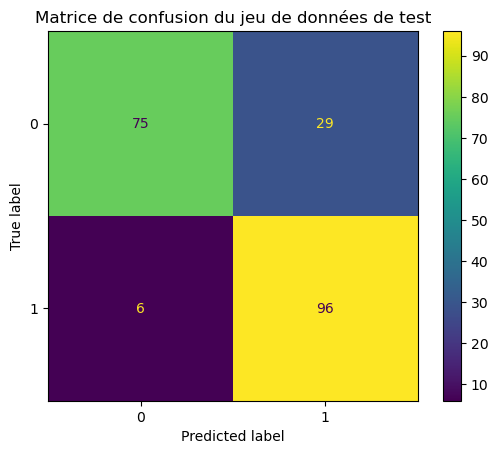

Score de précision du jeu de données de test 0.8300970873786407


In [163]:

print("Prédiction sur le jeu de données d'entrainement'...")
y_train_pred_rf = classifier_rf.predict(X_train_transformed)
print("...Fait")

print("Prédiction sur le jeu de données de test...")
y_test_pred_rf = classifier_rf.predict(X_test_transformed)
print("...Fait")

print("--- Evaluation des performances du modele ---")

cm_display = ConfusionMatrixDisplay.from_predictions(y_train_transformed, y_train_pred_rf)
cm_display.ax_.set_title("Matrice de confusion du jeu de données d'entrainement")
plt.show()
print("Score de précision du jeu de données d'entrainement", classifier_rf.score(X_train_transformed, y_train_transformed))

cm_display = ConfusionMatrixDisplay.from_predictions(y_test_transformed, y_test_pred_rf)
cm_display.ax_.set_title("Matrice de confusion du jeu de données de test")
plt.show()
print("Score de précision du jeu de données de test", classifier_rf.score(X_test_transformed, y_test_transformed))

In [164]:
coef_rf_aggregate_by_columns = getCoefAggregateByColumns(classifier_rf.feature_importances_)

feature_importance_rf = pd.DataFrame({
    "feature_names": all_column_names,
    "coefficients":coef_rf_aggregate_by_columns
})

feature_importance_rf.coefficients.sort_values()

12    0.000833
16    0.001431
4     0.001448
3     0.001512
14    0.001784
8     0.002469
15    0.002470
19    0.002554
17    0.002763
7     0.002964
10    0.002985
13    0.003241
0     0.003291
18    0.006076
11    0.006642
9     0.007723
20    0.016643
5     0.019005
21    0.019354
6     0.035896
2     0.143228
1     0.156917
Name: coefficients, dtype: float64

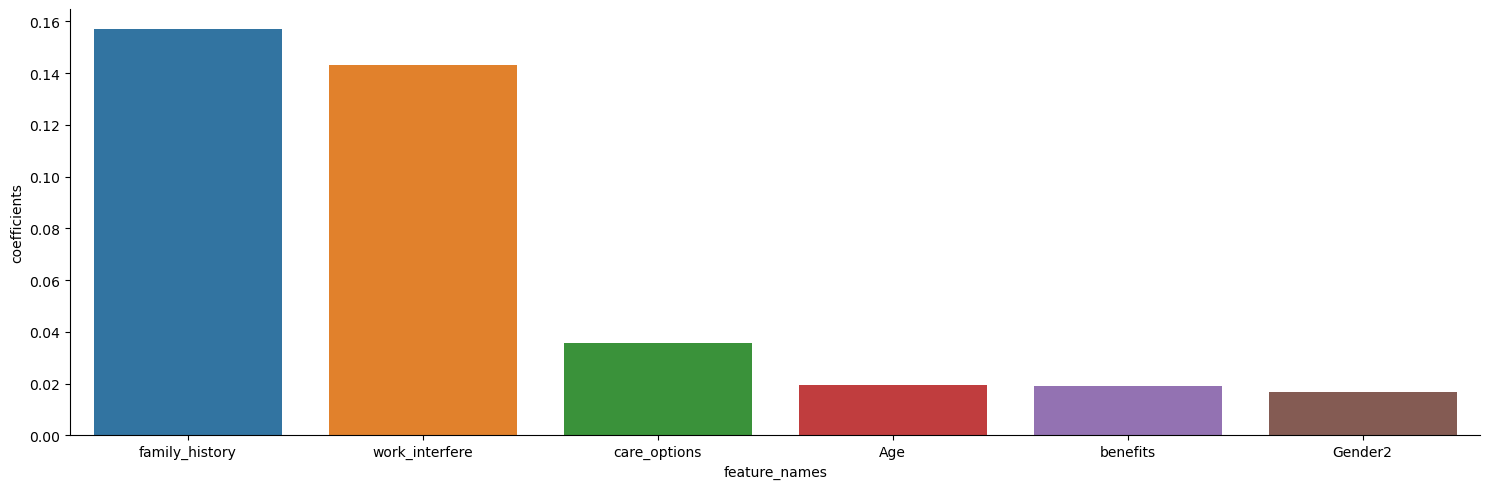

In [165]:
feature_importance_rf["coefficients"] = feature_importance_rf["coefficients"].abs()

sns.catplot(x="feature_names", 
            y="coefficients", 
            data=feature_importance_rf.sort_values(by="coefficients", ascending=False).head(6), 
            kind="bar",
            aspect=30/10, # Resize graph
            hue='feature_names')